In [1]:
import sagemaker

In [2]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [3]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
!rm -rf sourcedir.tar.gz && tar czvf sourcedir.tar.gz inference.py requirements.txt

inference.py
requirements.txt


In [5]:
source_dir = 's3://{0}/{1}/source/'.format(bucket, 'stablediffusion')
!aws s3 cp sourcedir.tar.gz $source_dir
source_dir = '{0}sourcedir.tar.gz'.format(source_dir)
!rm -f sourcedir.tar.gz

upload: ./sourcedir.tar.gz to s3://sagemaker-ap-east-1-034068151705/stablediffusion/source/sourcedir.tar.gz


In [6]:
!touch dummy
!tar czvf model.tar.gz dummy
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-ap-east-1-034068151705/stablediffusion/assets/model.tar.gz


In [7]:
model_name = None
entry_point = 'inference.py'
framework_version = '1.10'
py_version = 'py38'
#model_environment = {'pretrained':'waifu-diffusion', 'SAGEMAKER_MODEL_SERVER_WORKERS': '1'}
model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT':'600', 
    'SAGEMAKER_MODEL_SERVER_WORKERS': '1', 
    'model_name':'naclbit/trinart_stable_diffusion_v2',
    'model_args': '{"revision": "diffusers-115k"}',
    'task': 'text-to-image'
}

In [8]:
from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    name = model_name,
    model_data = model_data,
    entry_point = entry_point,
    source_dir = source_dir,
    role = role,
    framework_version = framework_version, 
    py_version = py_version,
    env = model_environment
)

In [9]:
from sagemaker.async_inference import AsyncInferenceConfig
endpoint_name = None
instance_type = 'ml.g4dn.xlarge'
instance_count = 1
async_config = AsyncInferenceConfig(output_path='s3://{0}/{1}/asyncinvoke/out/'.format(bucket, 'stablediffusion'))

In [10]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
async_predictor = model.deploy(
    endpoint_name = endpoint_name,
    instance_type = instance_type, 
    initial_instance_count = instance_count,
    async_inference_config = async_config,
    serializer = JSONSerializer(),
    deserializer = JSONDeserializer()
)

----------!

In [12]:
inputs = {
    'inputs': {"prompt": "Manga drawing of Brad Pitt"}
}
response = async_predictor.predict_async(inputs)

In [13]:
from sagemaker.async_inference.waiter_config import WaiterConfig
print(f"Response object: {response}")
print(f"Response output path: {response.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
  max_attempts=100, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

response.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f7d63dfe438>
Response output path: s3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/out/7676a9f9-1f5e-4a4c-b258-b9041a8be361.out
Start Polling to get response:
Time taken: 421.7139947414398s


In [14]:
import json
import io
from PIL import Image
s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

['s3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/c8e942d4-b974-44e8-8a64-a678d798ba46.jpg', 's3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/3d396b42-685c-4a6d-8236-d97db299db22.jpg', 's3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/8972a89c-22dc-41d3-bc9c-a48b2052037e.jpg', 's3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/323eae00-77d8-48b3-8a51-1ea9de18792a.jpg', 's3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/4ce24fa2-8a54-4d95-8215-2683901f28d8.jpg', 's3://sagemaker-ap-east-1-034068151705/stablediffusion/asyncinvoke/images/6cef24a0-7d87-4e35-9b4f-ec91a4809593.jpg']


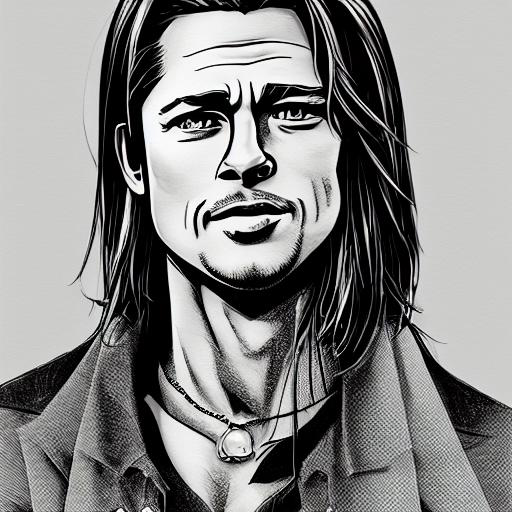

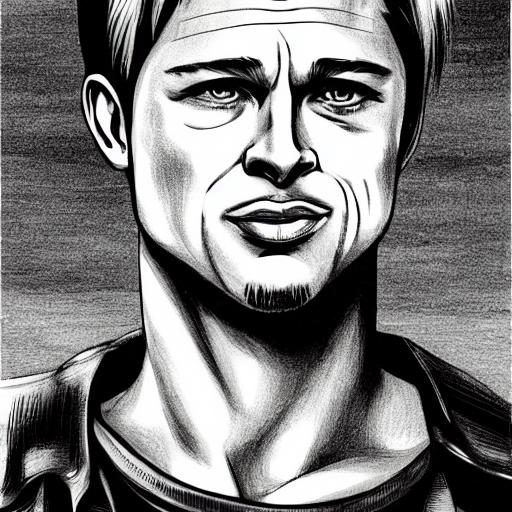

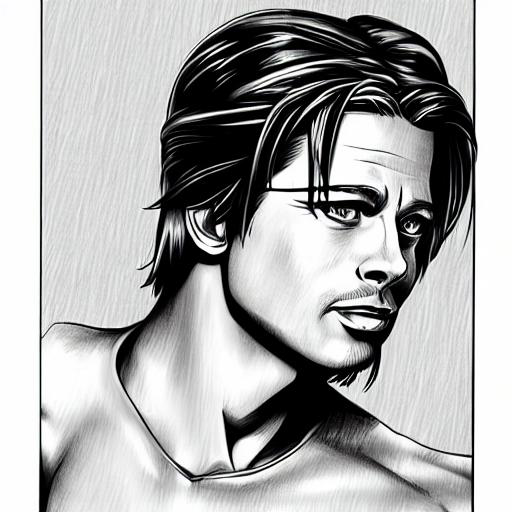

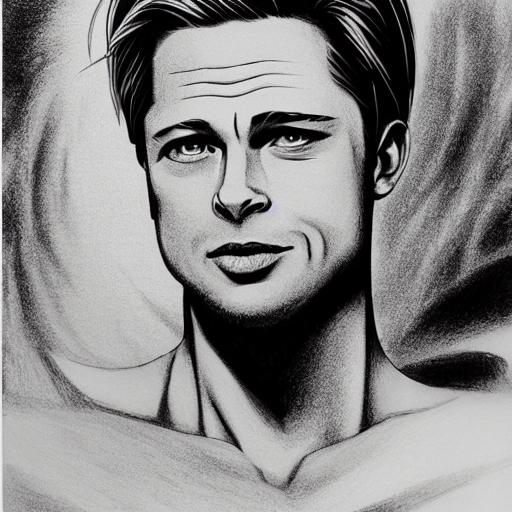

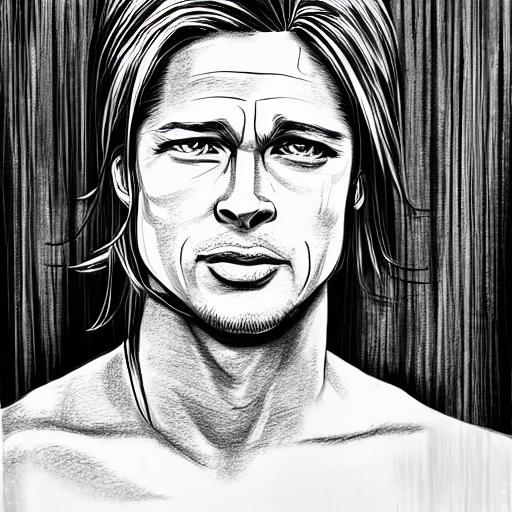

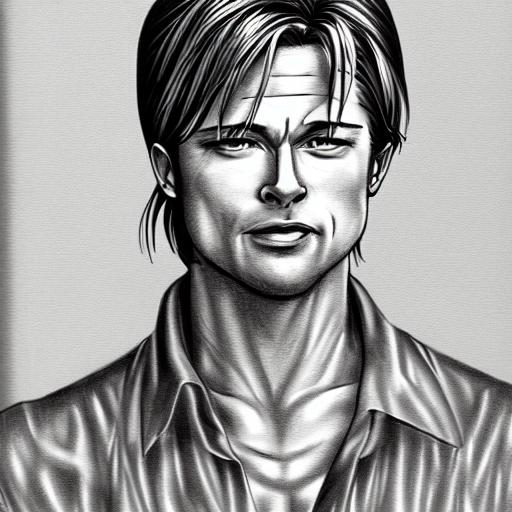

In [15]:
import traceback
try:
    bucket, key = get_bucket_and_key(response.output_path)
    obj = s3_resource.Object(bucket, key)
    body = obj.get()['Body'].read().decode('utf-8') 
    predictions = json.loads(body)['result']
    print(predictions)
    for prediction in predictions:
        bucket, key = get_bucket_and_key(prediction)
        obj = s3_resource.Object(bucket, key)
        bytes = obj.get()['Body'].read()
        image = Image.open(io.BytesIO(bytes))
        image.show()
except Exception as e:
    traceback.print_exc()
    print(e)

In [ ]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{async_predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
)

response = asg_client.put_scaling_policy(
    PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0,
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
        "ScaleOutCooldown": 300 # duration between scale out attempts
    },
)

In [ ]:
import time

start = time.time()

outputs=[]

# send 10 requests
for i in range(10):
    prediction = async_predictor.predict_async(data={"inputs": "A magical dragon flying in front of the Himalaya in manga style"})
    outputs.append(prediction)

# iterate over list of output paths and get results
results = []
for output in outputs:
    response = output.get_result(WaiterConfig(max_attempts=600))
    results.append(response)

print(f"Time taken: {time.time() - start}s")

In [ ]:
print(results)

In [ ]:
response = asg_client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)
#async_predictor.delete_endpoint()